## AI for finance [IE 412]

### Homework 1

### Step 0. Load package.


In [1]:
import os
import random
import warnings

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
import yfinance as yf

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import torch
import torch.nn as nn
import torch.optim as optim

warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=FutureWarning)

FIXED_SEED = 2023
random.seed(FIXED_SEED)
np.random.seed(FIXED_SEED)

### Step 1. Code block 

- Here's a block of code that corresponds to **Quiz 1, 2.1 and 2.2** in this Step.
- Notice that each quiz is not the main problem.

In [2]:
class Arguments:
    def __init__(self):
        self.args = {
            "root_path": "./data/",
            "data_path": "stock_data.csv",
            "symbol": "SBUX",
            "valid_size": 0.2,
            "test_size": 0.1,
            # for LSTM(Optional model)
            "seq_len" : 30,
            "n_layers" : 2,
            "n_hidden" : 16
        }

    def get_args(self):
        return self.args

In [3]:
def fetch_stock_data(symbol):
    """
    Fetch the stock data for a given symbol using Yahoo Finance API.

    Args:
        symbol (str): Stock symbol to fetch data for.

    Returns:
        pandas.DataFrame: Stock data for the given symbol.
    """
    ticker = yf.Ticker(symbol)
    data = ticker.history(period="5y", interval="1d").iloc[:, :5].reset_index()
    data['Close'] = data['Close'].shift(-1) # Quiz 1. Why use shift -1?
    data.dropna(inplace=True)
    data.drop(columns=['Volume'], inplace=True)
    return data

In [4]:
def split_data(data, valid_size, test_size):
    """
    Split the stock data into train, validation, and test sets.

    Args:
        data (pandas.DataFrame): Stock data to split.
        valid_size (float): Proportion of data to use for validation set.
        test_size (float): Proportion of data to use for test set.

    Returns:
        tuple: Train, validation, and test data as pandas DataFrames.
    """
    test_split_idx = int(data.shape[0] * (1 - test_size))
    valid_split_idx = int(data.shape[0] * (1 - (valid_size + test_size)))

    train_data = data.loc[:valid_split_idx].copy()
    valid_data = data.loc[valid_split_idx + 1:test_split_idx].copy()
    test_data = data.loc[test_split_idx + 1:].copy()

    train_data.drop(columns=['Date'], inplace=True)
    valid_data.drop(columns=['Date'], inplace=True)
    test_data.drop(columns=['Date'], inplace=True)

    return train_data, valid_data, test_data


In [5]:
def create_xgb_model(parameters, X_train, y_train, X_valid, y_valid):
    """
    Create and train an XGBoost model using GridSearchCV for hyperparameter tuning.

    Args:
        parameters (dict): Parameters to use for hyperparameter tuning.
        X_train (pandas.DataFrame): Training feature set.
        y_train (pandas.Series): Training target set.
        X_valid (pandas.DataFrame): Validation feature set.
        y_valid (pandas.Series): Validation target set.

    Returns:
        xgboost.XGBRegressor: Trained XGBoost model.
    """
    model = xgb.XGBRegressor(objective='reg:squarederror', verbosity=0) 
    clf = GridSearchCV(model, parameters, n_jobs=-1, cv=5) 
    clf.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_valid, y_valid)], early_stopping_rounds=10, verbose=False)

    print(f'Best params: {clf.best_params_}')
    print(f'Best validation score = {clf.best_score_}')

    model = xgb.XGBRegressor(**clf.best_params_, objective='reg:squarederror', verbosity=0)
    model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_valid, y_valid)], verbose=False)

    return model



In [6]:
def plot_predictions(original_data, test_data, predictions):
    fig, ax1 = plt.subplots(figsize=(10, 5))
    sns.lineplot(x=original_data.Date, y=original_data.Close, ax=ax1, color='LightSkyBlue', label='Truth')
    sns.lineplot(x=test_data.Date, y=predictions, ax=ax1, color='red', label='Prediction')
    ax1.legend()
    plt.show()


In [7]:
def main(symbol):
    """
    Main function to fetch stock data, train XGBoost model, and make predictions.

    Args:
        symbol (str): Stock symbol to fetch data for and train the model.

    Returns:
        tuple: Predicted stock prices, true stock prices, and validation data.
    """
    ...    
    warnings.filterwarnings('ignore')
    warnings.filterwarnings('ignore', category=FutureWarning)

    args = Arguments().get_args()
    args["symbol"] = symbol

    df = fetch_stock_data(args["symbol"])

    train_df, valid_df, test_df = split_data(df, args["valid_size"], args["test_size"])

    y_train = train_df['Close'].copy()
    X_train = train_df.drop(['Close'], 1)

    y_valid = valid_df['Close'].copy()
    X_valid = valid_df.drop(['Close'], 1)

    y_test = test_df['Close'].copy()
    X_test = test_df.drop(['Close'], 1)

    parameters = {
        'n_estimators': [100, 200, 300, 400],
        'learning_rate': [0.1, 0.01],
        'max_depth': [8, 10, 12],
        'gamma': [0.001, 0.005, 0.01],
        'random_state': [FIXED_SEED]
    }

    model = create_xgb_model(parameters, X_train, y_train, X_valid, y_valid)
    y_pred = model.predict(X_test)

    print(f'Test Mean Squared Error for {symbol}: {mean_squared_error(y_test, y_pred)}')

    return y_pred, y_test, valid_df


In [8]:
y_pred_SBUX, y_test_SBUX, y_val_SBUX = main("SBUX")
y_pred_AAPL, y_test_AAPL, y_val_AAPL = main("AAPL")
y_pred_WMT , y_test_WMT,  y_val_WMT= main("WMT")
y_pred_JPM , y_test_JPM,  y_val_JPM= main("JPM")
y_pred_PFE , y_test_PFE,  y_val_PFE= main("PFE")

Best params: {'gamma': 0.005, 'learning_rate': 0.1, 'max_depth': 12, 'n_estimators': 300, 'random_state': 2023}
Best validation score = -0.3239137678392886
Test Mean Squared Error for SBUX: 3.4058243597927502
Best params: {'gamma': 0.005, 'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 300, 'random_state': 2023}
Best validation score = 0.5579702441798862
Test Mean Squared Error for AAPL: 69.43481454072287
Best params: {'gamma': 0.001, 'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 200, 'random_state': 2023}
Best validation score = 0.5595514070504353
Test Mean Squared Error for WMT: 13.149356496939436
Best params: {'gamma': 0.01, 'learning_rate': 0.1, 'max_depth': 12, 'n_estimators': 300, 'random_state': 2023}
Best validation score = 0.3088208612239458
Test Mean Squared Error for JPM: 10.876254825371317
Best params: {'gamma': 0.005, 'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 200, 'random_state': 2023}
Best validation score = 0.7298586676116016
Test Mean Squared E

In [9]:
y_pred_AAPL = [148.21555, 150.26488, 150.9607 , 147.48242, 149.53395, 150.26686,
       147.82918, 143.95766, 140.83365, 147.46365, 147.58234, 147.303  ,
       146.06606, 142.84431, 140.51878, 142.783  , 141.87097, 143.96791,
       144.97183, 142.79839, 135.73747, 134.83418, 131.74571, 131.44954,
       134.5735 , 131.82544, 131.06242, 129.9328 , 125.92498, 129.21379,
       129.39684, 124.74855, 126.0878 , 124.68383, 129.21239, 129.93776,
       129.94664, 132.97087, 132.96404, 134.46283, 135.36076, 134.9656 ,
       134.95198, 138.3755 , 140.82263, 141.6819 , 141.21211, 143.33273,
       145.40358, 142.81017, 143.92068, 144.97183, 150.17807, 153.53969,
       151.00337, 153.80205, 151.56091, 150.51727, 151.22223, 153.53969,
       152.40211, 154.67648, 153.46565, 152.45602, 148.21863, 148.65385,
       149.21194, 146.56934, 147.81393, 147.1957 , 144.98949, 145.61479,
       150.95073, 153.53969, 151.92224, 152.67566, 150.61623, 148.21863,
       150.26346, 152.09668, 152.40211, 154.42865, 154.77545, 154.34009,
       154.34009, 154.34009, 154.34009, 154.34009, 154.34009, 154.34009,
       154.34009, 154.34009, 154.34009, 154.34009, 154.34009, 154.34009,
       154.34009, 154.34009, 154.34009, 154.34009, 154.34009, 154.34009,
       154.34009, 154.34009, 154.34009, 154.34009, 154.34009, 154.34009,
       154.34009, 154.34009, 154.34009, 154.34009, 154.34009, 154.34009,
       154.34009, 154.34009, 154.34009, 154.34009, 154.34009, 154.34009,
       154.34009, 154.34009, 154.34009, 154.34009, 154.34009]

y_val_AAPL= [144.0100708 , 144.9941864 , 144.62640381, 147.5887146 ,
       149.27862549, 146.19702148, 150.10369873, 152.13157654,
       154.42788696, 153.175354  , 152.04212952, 150.70014954,
       155.85931396, 156.41601562, 161.54536438, 160.55131531,
       159.06019592, 165.14389038, 164.82579041, 164.59684753,
       164.11901855, 164.16879272, 168.46913147, 167.72253418,
       171.31610107, 172.40112305, 172.24185181, 173.75492859,
       173.35673523, 170.73872375, 166.80673218, 166.46827698,
       166.76690674, 169.25552368, 162.87469482, 160.64492798,
       158.18617249, 156.50386047, 157.24050903, 155.10028076,
       153.8261261 , 155.24960327, 153.75645447, 156.65318298,
       162.68556213, 153.13925171, 154.60255432, 151.6759491 ,
       150.01356506, 153.77633667, 156.18531799, 153.01980591,
       152.04426575, 149.74478149, 150.08323669, 151.06874084,
       149.1574707 , 141.83100891, 137.57048035, 141.8011322 ,
       145.43450928, 145.73313904, 144.76756287, 139.45188904,
       139.78038025, 138.34695435, 137.70985413, 142.33868408,
       137.74967957, 141.76133728, 143.0952301 , 143.20472717,
       142.73684692, 146.59919739, 148.76925659, 151.64608765,
       148.66972351, 144.14044189, 155.03060913, 152.64152527,
       149.96377563, 144.36938477, 138.24742126, 137.97819519,
       138.51661682, 139.09494019, 134.4783783 , 146.44352722,
       149.26531982, 147.84944153, 149.60432434]

y_test_AAPL = [148.35795593, 150.28234863, 150.85069275, 147.58023071,
       149.74391174, 150.63134766, 147.6799469 , 143.80123901,
       140.76008606, 147.60017395, 147.87934875, 147.3808136 ,
       146.20423889, 142.49504089, 140.53076172, 142.23579407,
       141.74720764, 144.07044983, 145.04760742, 142.79417419,
       136.10365295, 134.11943054, 131.98562622, 131.91584778,
       135.05670166, 131.84603882, 131.47712708, 129.6524353 ,
       125.67401886, 129.23365784, 129.55271912, 124.70683289,
       125.9930954 , 124.65698242, 129.24362183, 129.77207947,
       130.35040283, 133.10238647, 133.02261353, 134.36869812,
       135.54527283, 134.81739807, 134.87722778, 137.46966553,
       140.70025635, 142.11613464, 141.44807434, 143.54199219,
       145.5062561 , 142.58477783, 143.87101746, 145.00770569,
       150.38206482, 154.05137634, 151.28942871, 154.20094299,
       151.47888184, 150.43191528, 150.80140686, 153.63749695,
       152.98838806, 155.115448  , 153.49769592, 152.33929443,
       148.27490234, 148.70431519, 149.19363403, 146.50735474,
       147.71568298, 147.20639038, 145.10928345, 145.70846558,
       150.82138062, 153.61752319, 151.39060974, 152.65884399,
       150.38198853, 148.2948761 , 150.26216125, 152.37922668,
       152.77868652, 155.63473511, 154.78590393, 157.18258667,
       159.0599823 , 157.61199951, 158.71046448, 160.02865601,
       158.06137085, 157.43223572, 160.54794312, 162.13574219,
       164.67222595, 165.94047546, 165.40122986, 163.53379822,
       164.43255615, 161.80618286, 160.57789612, 159.87886047,
       165.33131409, 164.98181152, 165.00177002, 166.24006653,
       167.39846802, 166.4197998 , 164.79206848, 165.10163879,
       163.54379272, 163.53379822, 168.17738342, 169.44561768,
       169.35574341, 168.30718994, 167.21870422, 165.56098938,
       173.33026123, 173.26034546, 171.53274536, 173.32026672,
       173.51000977, 172.57000732, 172.07000732, 172.07000732,
       172.69000244]

In [10]:
y_pred_SBUX = [ 96.17776 ,  95.96061 ,  97.36963 ,  97.47973 ,  97.48546 ,
        98.53312 ,  98.63818 ,  97.80526 ,  97.63984 , 100.88598 ,
       102.86454 , 104.06033 , 102.59671 , 100.40636 , 100.59106 ,
       102.946045, 100.441124, 101.730515, 100.92907 , 100.82241 ,
        98.98321 ,  97.82185 ,  97.60582 ,  97.41922 ,  97.81234 ,
        96.293655,  97.471016,  97.84556 ,  97.847015,  98.888115,
        97.87227 ,  99.44639 , 103.04853 , 102.9017  , 105.434006,
       104.0563  , 104.50915 , 105.41631 , 104.50915 , 106.232925,
       105.41631 , 104.0563  , 102.89767 , 104.07399 , 105.434006,
       105.41631 , 106.197624, 107.60529 , 107.99346 , 107.40398 ,
       107.988464, 109.05551 , 107.992035, 102.90356 , 104.01674 ,
       105.434006, 105.41631 , 105.41631 , 106.45825 , 107.98619 ,
       107.43317 , 108.44591 , 106.83686 , 106.460526, 104.0563  ,
       104.0563  , 102.89767 , 100.400116, 101.87553 , 101.69908 ,
       100.441124, 102.6524  , 104.14598 , 104.52684 , 102.848946,
       101.807884,  98.88812 ,  98.765076,  98.60364 ,  98.85397 ,
        98.80623 ,  99.39    ,  97.93211 ,  99.3809  , 100.56888 ,
        98.64476 ,  97.858696,  97.88921 ,  97.81272 ,  98.509125,
       100.544945, 100.807175, 103.07303 , 104.06033 , 102.91536 ,
       104.52684 , 104.0563  , 104.07399 , 105.434006, 104.50915 ,
       106.449554, 106.84186 , 107.60757 , 107.43172 , 106.69229 ,
       106.460526, 107.612564, 108.57915 , 108.60024 , 110.687225,
       112.06789 , 113.58685 , 113.88967 , 113.89756 , 102.95424 ,
       104.04324 , 106.6576  , 106.67963 , 106.21152 , 106.456825,
       105.37584 , 106.18083 , 106.67963 , 105.39952 , 105.39952 ]

y_val_SBUX = [76.25237274, 76.11532593, 76.27194214, 76.54602051, 77.93599701,
       78.53309631, 80.80401611, 81.50878143, 81.77307129, 81.82201385,
       79.77622223, 78.61139679, 81.20534515, 82.87917328, 82.98685455,
       83.11410522, 81.93948364, 85.42417908, 85.04243469, 83.91675568,
       83.90697479, 83.045578  , 84.66068268, 85.91090393, 86.93470764,
       87.77147675, 88.00773621, 86.97408295, 87.17097473, 85.56636047,
       83.62703705, 83.37108612, 84.70990753, 86.02903748, 82.75089264,
       82.80995941, 82.11102295, 82.76074219, 84.07003021, 81.64834595,
       83.20373535, 86.93470764, 88.06679535, 87.30879211, 87.68286896,
       86.47202301, 91.25634003, 90.78382111, 89.88798523, 90.70506287,
       89.376091  , 87.22019196, 83.38092804, 82.85918427, 83.48921967,
       82.96746826, 85.75340271, 85.22180176, 82.94777679, 84.28660583,
       87.13159943, 88.71652985, 87.95851135, 85.67463684, 85.70417786,
       84.86740875, 85.51713562, 87.97820282, 85.02492523, 87.51552582,
       87.57458496, 86.15700531, 85.43837738, 87.2300415 , 82.45556641,
       83.88298798, 84.55239868, 83.95189667, 85.74354553, 85.24149323,
       85.74354553, 83.26280212, 83.3612442 , 90.4294281 , 89.04138184,
       91.30556488, 90.72141266, 95.30550385, 96.41439819, 96.45400238,
       96.85993958]

y_test_SBUX = [ 96.10746765,  96.008461  ,  96.97874451,  97.34507751,
        97.45398712,  98.53317261,  98.57277679,  97.68170929,
        97.68170929, 101.18659973, 102.34500885, 104.00834656,
       102.52322388, 101.0677948 , 100.85987854, 102.71133423,
       100.78067017, 101.68164062, 101.09749603, 101.17670441,
        98.9985199 ,  97.85002136,  97.32527924,  97.02825165,
        97.69160461,  96.79063416,  97.29557037,  98.21634674,
        97.62229919,  98.78070068,  98.21634674,  99.83019257,
       103.42419434, 103.3944931 , 105.63208771, 103.70141602,
       104.9489212 , 105.24594879, 104.80041504, 106.16673279,
       105.69149017, 103.95884705, 103.22618103, 103.99845123,
       105.15684509, 105.58257294, 105.91921234, 107.68156433,
       107.9389801 , 107.32513428, 108.05779266, 108.89936066,
       108.06768799, 103.26578522, 103.97864532, 105.77069855,
       105.24594879, 105.52456665, 106.55940247, 107.98232269,
       107.44499969, 108.45994568, 107.00717926, 106.56935883,
       104.260849  , 104.25090027, 102.99714661, 101.09661102,
       101.93244934, 101.58417511, 100.92745209, 102.49962616,
       104.03199768, 104.46981049, 102.82798767, 101.99214935,
        99.80305481,  98.88760376,  98.58909607,  98.96720886,
        98.84780121,  99.93240356,  98.21097565,  99.35527802,
       100.04186249,  98.62889862,  97.93236542,  97.85276031,
        98.17118073,  98.23088074, 100.12146759, 100.81799316,
       103.61407471, 104.33050537, 103.48471832, 104.38025665,
       104.16134644, 104.22104645, 105.21609497, 105.07678986,
       106.4598999 , 106.93752289, 107.77336121, 107.37535095,
       106.62906647, 106.51960754, 107.65396118, 108.74851227,
       108.79825592, 110.91770935, 112.1913681 , 113.72373199,
       113.99239349, 113.89289093, 103.44491577, 104.20114899,
       106.67881012, 106.63900757, 106.18128967, 106.44000244,
       105.62999725, 106.12000275, 106.63999939, 105.27999878,
       105.69000244]

In [11]:
y_pred_WMT = [146.65472, 146.20609, 147.1549 , 147.1549 , 147.1549 , 147.1549 ,
       147.1549 , 147.1549 , 147.1549 , 147.1549 , 147.1549 , 147.1549 ,
       147.1549 , 147.1549 , 147.1549 , 147.1549 , 144.24292, 146.6469 ,
       146.34018, 145.46703, 144.2447 , 141.88658, 141.84033, 142.85866,
       144.06137, 142.45546, 142.77872, 142.79997, 140.2662 , 140.93303,
       140.81284, 142.45766, 142.80327, 142.02983, 145.62076, 143.78189,
       143.77063, 144.99652, 143.75838, 144.09521, 143.18228, 139.64798,
       137.60934, 139.6462 , 141.32133, 141.88011, 141.42163, 141.00793,
       142.02554, 141.03268, 142.79079, 143.47473, 142.45508, 140.32974,
       139.53494, 140.22043, 138.94554, 140.28531, 142.44397, 144.72029,
       144.27972, 145.4352 , 143.21774, 145.20006, 146.1354 , 143.1772 ,
       141.04266, 141.34532, 140.36334, 140.93303, 139.00647, 139.63788,
       139.57692, 139.67905, 137.95175, 136.94307, 136.38866, 135.76733,
       136.4012 , 136.9225 , 138.55383, 137.66446, 138.8119 , 140.20609,
       140.2468 , 138.96922, 140.2261 , 141.42128, 143.74605, 143.19724,
       143.74332, 145.04753, 146.65025, 147.1549 , 146.61986, 147.1549 ,
       147.1549 , 147.1549 , 147.1549 , 147.1549 , 147.1549 , 147.1549 ,
       147.1549 , 147.1549 , 147.1549 , 147.1549 , 147.1549 , 147.1549 ,
       147.1549 , 147.1549 , 147.1549 , 147.1549 , 147.1549 , 147.1549 ,
       147.1549 , 147.1549 , 147.1549 , 147.1549 , 147.1549 , 147.1549 ,
       147.1549 , 147.1549 , 147.1549 , 147.1549 , 147.1549 ]

y_val_WMT = [123.45996857, 123.08599091, 123.38124847, 125.79237366,
       127.02254486, 126.72731781, 127.504776  , 128.56764221,
       130.44734192, 130.11273193, 129.92575073, 120.04502106,
       124.58188629, 127.6917572 , 129.95527649, 130.4375    ,
       130.57527161, 128.42987061, 123.57806396, 124.572052  ,
       125.58570862, 126.82572174, 127.09143066, 128.31707764,
       130.68930054, 131.06491089, 137.7565155 , 137.90478516,
       137.45999146, 135.43371582, 133.01210022, 132.44868469,
       133.4074707 , 134.29704285, 130.07647705, 131.34165955,
       130.9462738 , 131.01547241, 132.92312622, 131.46026611,
       130.8079071 , 134.16854858, 134.85055542, 135.25579834,
       136.47158813, 133.65455627, 133.35803223, 131.92481995,
       131.64805603, 132.77488708, 132.00390625, 133.20977783,
       131.8457489 , 128.55430603, 129.78982544, 129.43399048,
       131.56898499, 130.71894836, 128.19847107, 130.99569702,
       132.69578552, 131.38117981, 130.15553284, 127.07167053,
       127.82286835, 131.13407898, 129.65144348, 130.74859619,
       128.92001343, 129.84912109, 132.58706665, 132.2114563 ,
       132.53762817, 135.21627808, 137.79606628, 138.44842529,
       139.50604248, 139.10075378, 140.86016846, 140.68225098,
       140.04966736, 139.12052917, 139.09089661, 139.3380127 ,
       140.8008728 , 141.13690186, 137.85536194, 140.71191406,
       140.92935181, 136.78787231, 145.73309326]

y_test_WMT = [146.7808075 , 146.28660583, 148.49078369, 149.40013123,
       149.93389893, 150.65544128, 151.29792786, 151.7328186 ,
       151.19908142, 150.65544128, 151.59443665, 151.44618225,
       149.89434814, 148.15472412, 147.3837738 , 147.61195374,
       144.16918945, 146.85792542, 146.33209229, 145.51852417,
       144.21881104, 141.62928772, 141.6789093 , 142.9190979 ,
       144.04022217, 142.3535614 , 142.64128113, 142.68096924,
       140.18074036, 141.03399658, 140.67681885, 142.47264099,
       142.63136292, 142.1452179 , 145.62765503, 143.81202698,
       143.72273254, 144.98275757, 143.67311096, 144.14933777,
       143.27627563, 139.73428345, 137.74008179, 139.43663025,
       141.52017212, 141.89717102, 141.22250366, 141.09353638,
       142.17498779, 141.03399658, 142.74050903, 143.53422546,
       142.49246216, 140.59745789, 139.57554626, 139.8731842 ,
       139.11915588, 140.40895081, 142.59169006, 144.76449585,
       144.34779358, 145.41931152, 143.13735962, 145.29032898,
       146.17333984, 143.10760498, 140.97447205, 141.35150146,
       140.32957458, 141.01416016, 139.04969788, 139.3969574 ,
       139.56562805, 139.54577637, 138.1567688 , 137.01580811,
       136.09309387, 135.89468384, 136.29153442, 137.01580811,
       138.54371643, 137.75669861, 138.87245178, 140.36677551,
       139.88859558, 138.99200439, 140.11772156, 141.26338196,
       143.62440491, 143.06652832, 143.68417358, 145.11872864,
       146.89199829, 148.12730408, 146.67282104, 149.10359192,
       150.22932434, 149.94041443, 149.50209045, 148.77484131,
       148.92428589, 147.91809082, 148.9541626 , 149.28291321,
       149.44230652, 150.39868164, 151.15579224, 152.18190002,
       150.99641418, 150.33891296, 150.80712891, 150.39868164,
       151.0163269 , 150.60787964, 150.04998779, 150.47000122,
       151.77000427, 152.72000122, 152.97999573, 152.55000305,
       153.11999512, 153.07000732, 151.88000488, 149.77999878,
       149.52999878]

In [12]:
y_pred_JPM = [131.23552 , 130.85641 , 131.23465 , 131.1954  , 133.00816 ,
       135.18517 , 134.70721 , 134.29308 , 136.47008 , 135.18517 ,
       136.47008 , 136.74803 , 129.66    , 129.66638 , 129.62839 ,
       131.13199 , 129.5088  , 132.69644 , 133.10182 , 133.0879  ,
       127.85308 , 127.579475, 127.65199 , 129.39708 , 129.53284 ,
       129.39565 , 129.39708 , 129.52898 , 131.13199 , 131.11018 ,
       132.6967  , 132.64148 , 134.67807 , 136.47008 , 136.47008 ,
       138.925   , 138.925   , 138.98991 , 138.925   , 141.94121 ,
       137.28947 , 138.77193 , 136.74803 , 134.29308 , 136.47008 ,
       136.47008 , 138.925   , 138.98991 , 139.16179 , 138.925   ,
       139.02415 , 139.02415 , 138.925   , 140.08234 , 140.27286 ,
       142.30179 , 141.5756  , 139.47609 , 140.02275 , 141.49971 ,
       142.06317 , 142.34709 , 140.3453  , 141.45836 , 139.02415 ,
       138.925   , 139.02415 , 139.65765 , 141.39433 , 142.09639 ,
       141.61047 , 140.1142  , 142.23889 , 141.59076 , 138.65077 ,
       138.77193 , 133.8562  , 136.74803 , 129.48187 , 133.0622  ,
       129.79807 , 129.53284 , 125.199554, 126.94868 , 129.46626 ,
       126.69437 , 125.41264 , 124.33964 , 127.43442 , 127.660515,
       127.65199 , 127.552185, 129.39708 , 129.39708 , 127.579475,
       127.552185, 127.660515, 127.660515, 127.660515, 127.552185,
       129.40094 , 135.07246 , 139.65765 , 141.39433 , 141.46677 ,
       140.31938 , 140.3453  , 140.30981 , 138.77193 , 138.925   ,
       138.925   , 138.925   , 141.39433 , 138.84183 , 138.746   ,
       138.925   , 136.56068 , 138.925   , 138.925   , 138.925   ,
       138.925   , 134.38368 , 138.925   , 136.47008 , 138.925   ]

y_val_JPM = [110.17435455, 110.28173065, 109.24695587, 105.42999268,
       110.26220703, 109.12981415, 111.83389282, 111.8143692 ,
       112.57581329, 112.02912903, 112.47818756, 110.72101593,
       112.49770355, 112.07794189, 112.61486053, 111.49222565,
       109.75457764, 110.90650177, 109.68624115, 113.00534058,
       111.62888336, 112.63437653, 115.57274628, 117.28110504,
       119.22374725, 119.54589081, 120.68805695, 119.67281342,
       118.7454071 , 115.80702972, 113.89368439, 112.7710495 ,
       113.04438782, 115.7289505 , 111.94126892, 111.66793823,
       111.68746948, 111.02364349, 111.78508759, 111.00411224,
       111.03340149, 113.14200592, 115.77775574, 116.33419037,
       117.71063995, 113.62034607, 113.35677338, 115.06513214,
       114.29392242, 115.34822083, 113.07366943, 109.81314087,
       108.56360626, 106.54286957, 104.24879456, 103.33115387,
       105.42023468, 103.63378143, 102.01328278, 105.16642761,
       110.08647919, 108.72727966, 106.5111618 , 104.38370514,
       103.40860748, 100.42425537, 102.04940033, 107.72264099,
       109.51522827, 114.11489105, 117.04999542, 114.75509644,
       114.3808136 , 120.3889389 , 120.5366745 , 120.85185242,
       122.24061584, 122.72323608, 124.18095398, 123.98396301,
       126.21976471, 125.05754089, 125.28408051, 128.71165466,
       129.39126587, 129.47006226, 127.78583527, 133.04537964,
       133.2620697 , 131.89300537, 130.93762207]


y_test_JPM = [131.11491394, 130.54364014, 131.8240509 , 131.04595947,
       133.00598145, 134.42430115, 134.6803894 , 132.3263855 ,
       134.50309753, 136.09867859, 134.18791199, 133.12419128,
       129.39126587, 129.60794067, 129.51930237, 130.87852478,
       130.16937256, 132.18849182, 132.06045532, 131.40054321,
       128.14041138, 127.34259033, 128.10099792, 128.72151184,
       130.16937256, 128.69197083, 129.30262756, 129.75570679,
       130.46484375, 131.21340942, 132.08015442, 133.08477783,
       134.32580566, 134.29605103, 136.86587524, 136.30030823,
       137.52073669, 138.54270935, 138.40380859, 141.89639282,
       139.70359802, 135.50654602, 133.70071411, 134.02813721,
       136.20109558, 137.37190247, 138.03668213, 138.88998413,
       139.2273407 , 138.0466156 , 138.87014771, 138.50302124,
       137.85809326, 139.99133301, 140.81488037, 142.53140259,
       141.52926636, 139.32655334, 139.94172668, 141.45982361,
       142.08491516, 142.68023682, 140.71566772, 141.13238525,
       138.54270935, 137.48103333, 138.58239746, 139.83258057,
       141.05300903, 142.23374939, 141.43997192, 139.97151184,
       142.54133606, 141.70787048, 137.54057312, 136.72695923,
       129.32504272, 132.60926819, 130.22796631, 133.57171631,
       127.26124573, 129.7318573 , 124.83032227, 126.14997101,
       129.53341675, 126.18965912, 125.85230255, 123.93733978,
       127.48946381, 127.8764267 , 128.13439941, 127.74743652,
       129.29528809, 129.14645386, 127.41999817, 127.61000061,
       127.47000122, 127.88999939, 128.52000427, 128.5       ,
       128.99000549, 138.72999573, 139.83000183, 141.3999939 ,
       141.22000122, 140.80999756, 140.53999329, 140.72999573,
       137.66999817, 135.22999573, 137.05000305, 138.24000549,
       141.19999695, 138.91999817, 135.97999573, 134.11999512,
       136.74000549, 137.07000732, 136.41000366, 136.47999573,
       136.05000305, 134.1000061 , 135.22999573, 134.32000732,
       138.44999695]

In [13]:
y_pred_PFE = [47.127113, 47.36764 , 47.20322 , 47.20322 , 47.499237, 47.499237,
       47.499237, 47.499237, 47.499237, 47.499237, 47.499237, 47.499237,
       47.499237, 47.499237, 47.499237, 47.499237, 47.499237, 47.499237,
       47.499237, 47.499237, 47.499237, 47.499237, 47.499237, 47.499237,
       47.499237, 47.499237, 47.499237, 47.499237, 47.499237, 47.499237,
       47.499237, 47.499237, 47.499237, 47.499237, 47.499237, 47.36764 ,
       46.521526, 46.521526, 46.978554, 46.978554, 45.295765, 44.09428 ,
       44.083244, 44.07677 , 44.07677 , 43.800816, 44.07677 , 43.800816,
       43.29726 , 42.939247, 43.812042, 43.61528 , 43.812042, 43.61528 ,
       43.228085, 42.936573, 43.61528 , 43.008453, 43.29726 , 43.61528 ,
       43.29729 , 42.936573, 42.395004, 42.75115 , 42.17446 , 42.098656,
       41.69959 , 41.348953, 40.393566, 40.35782 , 39.926838, 40.351963,
       40.578842, 40.66712 , 39.88978 , 39.461563, 38.904068, 38.904068,
       39.54242 , 39.556805, 39.87703 , 39.86215 , 39.46319 , 40.399094,
       40.351963, 39.512   , 39.91135 , 39.91713 , 39.87703 , 39.4897  ,
       39.91713 , 39.91713 , 40.428726, 40.978424, 40.509922, 40.986366,
       40.986366, 41.348953, 41.330822, 40.958218, 40.986366, 40.637367,
       40.637367, 40.362923, 39.877647, 39.517326, 39.87703 , 39.46319 ,
       38.923767, 38.306164, 38.161602, 38.24842 , 38.8247  , 38.71414 ,
       38.153347, 37.6168  , 38.25202 , 38.25202 , 38.25202 , 37.718147,
       37.634933, 37.34186 , 37.150124, 37.028843, 36.834816]


y_val_PFE = [51.01140213, 50.19159698, 49.9504776 , 49.56468582, 49.91189575,
       48.9474144 , 49.5453949 , 49.01493073, 49.3042717 , 49.41036606,
       49.93118668, 50.44235992, 50.10479355, 49.29806519, 49.09394836,
       49.19114304, 48.29693604, 48.46217346, 48.46217346, 47.88871384,
       48.18030167, 48.38441849, 48.54964828, 46.93619156, 48.70516586,
       48.35525513, 48.46217346, 47.88871384, 47.21805573, 47.77207947,
       47.52908707, 46.66403961, 46.10029984, 46.55712128, 45.5073967 ,
       44.93393707, 44.56459427, 43.96197128, 45.32273102, 44.41880035,
       44.47711182, 44.83674622, 45.76011276, 46.49880219, 46.42104721,
       44.89506149, 44.8561821 , 44.65206909, 44.73954391, 44.16608429,
       43.5148735 , 42.68869781, 43.32047653, 42.84421921, 42.60122681,
       42.85393906, 43.18440247, 42.92197418, 42.53318405, 42.90253448,
       43.2135582 , 42.88309479, 41.88196945, 41.13356018, 40.57953644,
       40.74477005, 40.85168457, 41.77505493, 41.65842056, 42.42627335,
       42.85393906, 41.90140915, 41.70701981, 43.68982315, 44.26328659,
       44.31188583, 44.76870728, 44.45767975, 46.10029984, 45.2449646 ,
       46.66403961, 45.7503891 , 45.65236282, 46.2895546 , 46.162117  ,
       46.41699219, 45.79940414, 46.44639969, 46.66205978, 48.26974869,
       47.61294937]

y_test_PFE = [47.10319519, 47.37768173, 47.27965164, 47.2306366 , 48.11290359,
       47.8874321 , 48.24033737, 48.59324265, 48.51482391, 49.14221191,
       50.07349777, 49.90684128, 49.73038864, 48.73048782, 49.25004578,
       50.75969696, 50.70088196, 51.13220978, 52.02428055, 53.40649796,
       52.55363846, 50.38718796, 50.34797668, 50.3087616 , 50.64206314,
       50.6224556 , 50.80871582, 50.12250519, 49.79900742, 50.31856537,
       50.23034286, 50.24994278, 49.14221191, 48.68147278, 49.91664124,
       47.43649673, 46.68167114, 46.51501846, 46.76989746, 46.90713501,
       45.17201614, 44.11329651, 44.07408142, 44.22112656, 44.09368896,
       43.82901001, 44.1819191 , 43.77630615, 43.32123184, 43.08379745,
       43.68727112, 43.49930573, 43.865345  , 43.58834076, 43.29154968,
       43.12337112, 43.50919724, 42.87604904, 43.41026688, 43.51909256,
       43.25197983, 42.85626221, 42.49022293, 42.74744034, 42.24290085,
       41.92632675, 41.84717941, 41.30307007, 40.34345245, 40.13570023,
       39.74987793, 40.18516541, 40.70949173, 40.66992188, 39.90816498,
       39.69051743, 39.0375824 , 38.96833038, 39.43330002, 39.47287369,
       39.84880447, 39.93783951, 39.67073059, 40.37313461, 40.22473907,
       39.58169556, 39.74987793, 39.95762634, 39.78944778, 39.56191254,
       39.81912613, 39.94773483, 40.36323929, 40.90734863, 40.46216965,
       41.10520935, 41.05574417, 41.28328323, 41.34263992, 40.92713547,
       41.02606583, 40.74906158, 40.73917007, 40.11591339, 39.80923462,
       39.42340851, 39.77955246, 39.4827652 , 38.90897751, 38.21646881,
       38.32529068, 38.47368622, 38.79026031, 38.64186478, 38.03839493,
       37.82075119, 38.0779686 , 38.25603867, 38.06807327, 37.88999939,
       37.58000183, 37.34999847, 37.15999985, 37.00999832, 36.75      ]

### Step 2. Portfolio optimization

- Here's a block of code that corresponds to **Main Problem** in this Step.

In [14]:
import cvxpy as cp
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


def create_dataframes(y_AAPL, y_SBUX, y_WMT, y_JPM, y_PFE):
    """
    Args:
        y_AAPL (numpy.ndarray):  stock close prices for AAPL.
        y_SBUX (numpy.ndarray):  stock close prices for SBUX.
        y_WMT (numpy.ndarray):  stock close prices for WMT.
        y_JPM (numpy.ndarray):  stock close prices for JPM.
        y_PFE (numpy.ndarray):  stock close prices for PFE.

    Returns:
        tuple: DataFrames containing close prices and log returns.
    """
    df_close = pd.DataFrame({'AAPL': y_AAPL,
                             'SBUX': y_SBUX,
                             'WMT': y_WMT,
                             'JPM': y_JPM,
                             'PFE': y_PFE})
    df_logret = np.log(df_close / df_close.shift(1)).dropna()
    return df_close, df_logret


def calculate_mu_sigma(df_logret):
    """
    Args:
        df_logret (pd.DataFrame): DataFrame containing the log returns of the stocks.

    Returns:
        tuple: Mean returns (mu) and covariance matrix (Sigma) of the assets.
    """
    mu_df = df_logret.mean() * len(df_logret)
    Sigma_df = df_logret.cov() * len(df_logret)
    mu = mu_df.to_numpy()
    Sigma = Sigma_df.to_numpy()
    return mu, Sigma


In [15]:
def min_volatility_portfolio(mu, Sigma):
    """
    Args:
        mu (numpy.ndarray): Mean returns of the assets.
        Sigma (numpy.ndarray): Covariance matrix of the assets.

    Returns:
        numpy.ndarray: Portfolio asset weights corresponding to minimum volatility.
    """
    # Find the portfolio asset weights that maximize the portfolio return.
    # Objective : min vol
    # constraints 1: the sum of the asset weight is to 1
    # constraints 2: The asset weight are non-negative

    w_1 = cp.Variable(5)
    risk_1 = cp.quad_form(w_1, Sigma)
    prob_1 = cp.Problem(cp.Minimize(risk_1),          # objective
                        [cp.sum(w_1) == 1, w_1 >= 0]  # constraints 1, 2
                       )
    prob_1.solve()
    return w_1.value


def max_return_portfolio(mu, Sigma):
    """
    Args:
        mu (numpy.ndarray): Mean returns of the assets.
        Sigma (numpy.ndarray): Covariance matrix of the assets.

    Returns:
        numpy.ndarray: Portfolio asset weights corresponding to maximum return.
    """
    w_2 = cp.Variable(5)
    ret_2 = mu.T @ w_2

    # Referring to Code min_volatility_portfolio,
    # Find the portfolio asset weights that maximize the portfolio return.
    # Objective : Maximize return
    # constraints 1: the sum of the asset weight is to 1
    # constraints 2: The asset weight are non-negative
    
    prob_2 = cp.Problem(cp.Maximize(ret_2),
                        [cp.sum(w_2) == 1,
                         w_2 >= 0])
    prob_2.solve()
    return w_2.value

def mean_variance_efficient_portfolio(mu, Sigma, min_return):
    """
    Args:
        mu (numpy.ndarray): Mean returns of the assets.
        Sigma (numpy.ndarray): Covariance matrix of the assets.
        min_return (float): Minimum expected return for the portfolio.

    Returns:
        numpy.ndarray: Portfolio asset weights corresponding to a mean-variance efficient portfolio.
    """
    w_3 = cp.Variable(5)
    risk_3 = cp.quad_form(w_3, Sigma)
    ret_3 = mu.T @ w_3
    ######################### Main Problem #################################
    # 1) Find the portfolio asset weights that mean-variance efficient portfolio.
    # Objective : mean-variance efficient portfolio
    # constraints 1 w_3: the sum of the asset weight is to 1
    # constraints 2 ret_3: The asset weights are non-negative 
    # constraints 3: The expected return is greater than or equal to the min_return
    
    prob_3 = cp.Problem(cp.Minimize(risk_3),
                        [cp.sum(w_3) == 1,
                         w_3 >= 0,
                         ret_3 >= min_return])
    # More information is here! https://www.cvxpy.org/index.html
    # 2)	Obtain at least 5 different mean-variance efficient portfolios and plot them on the mean-standard deviation plane along with
    # the minimum volatility portfolio and the maximum return portfolio.

    ##################################################################
    prob_3.solve()
    return w_3.value


In [16]:
def monte_carlo_simulation(mu, Sigma, num_simulation, num_assets):
    """
    Args:
        mu (numpy.ndarray): Mean returns of the assets.
        Sigma (numpy.ndarray): Covariance matrix of the assets.
        num_simulation (int): Number of simulations to run.
        num_assets (int): Number of assets in the portfolio.

    Returns:
        tuple: Arrays containing the weights, returns, volatilities, and Sharpe ratios of the simulated portfolios.
    """
    all_weights = np.zeros((num_simulation, num_assets))
    ret_arr = np.zeros(num_simulation)
    vol_arr = np.zeros(num_simulation)
    sharpe_arr = np.zeros(num_simulation)

    for x in range(num_simulation):
        weights = np.array(np.random.random(num_assets))
        weights = weights / np.sum(weights)

        all_weights[x, :] = weights
        ret_arr[x] = mu.dot(weights)
        vol_arr[x] = np.sqrt(weights.dot(Sigma).dot(weights))
        sharpe_arr[x] = ret_arr[x] / vol_arr[x]

    return all_weights, ret_arr, vol_arr, sharpe_arr


In [17]:
def efficient_frontier(mu, Sigma, min_vol, max_ret):
    """
    Args:
        mu (numpy.ndarray): Mean returns of the assets.
        Sigma (numpy.ndarray): Covariance matrix of the assets.
        min_vol (float): Minimum volatility of the efficient frontier.
        max_ret (float): Maximum return of the efficient frontier.

    Returns:
        tuple: Arrays containing the volatilities and returns of the efficient frontier.
    """
    x_ef = []
    y_ef = np.linspace(min_vol, max_ret, 1000)

    for possible_return in y_ef:
        w = cp.Variable(5)
        ret = mu.T @ w
        risk = cp.quad_form(w, Sigma)
        prob = cp.Problem(cp.Minimize(risk),
                          [cp.sum(w) == 1,
                           ret == possible_return,
                           w >= 0])
        prob.solve()
        x_ef.append(np.sqrt(w.value.dot(Sigma).dot(w.value)))
        # If none value arises, it means that no optimal solution was found to return.

    return x_ef, y_ef


In [18]:
def plot_results(vol_arr, ret_arr, sharpe_arr, x_ef, y_ef, min_vol, min_vol_ret, 
                 max_ret, max_ret_vol, mu=0, Sigma=0, eff_list=[], filename="answer.png"):
    """
    Args:
        vol_arr (numpy.ndarray): Array of portfolio volatilities.
        ret_arr (numpy.ndarray): Array of portfolio returns.
        sharpe_arr (numpy.ndarray): Array of portfolio Sharpe ratios.
        x_ef (list): List of volatilities on the efficient frontier.
        y_ef (list): List of returns on the efficient frontier.
        min_vol (float): Minimum volatility.
        min_vol_ret (float): Return corresponding to the minimum volatility.
        max_ret (float): Maximum return.
        max_ret_vol (float): Volatility corresponding to the maximum return.

    Returns:
        None(Plot)
    """
    sns.set_style('darkgrid')
    plt.figure(figsize=(12, 4))
    plt.scatter(vol_arr, ret_arr, c=sharpe_arr, cmap='twilight')
    plt.colorbar(label='Sharpe Ratio')
    plt.xlabel('Volatility')
    plt.ylabel('Return')
    plt.plot(x_ef, y_ef, 'r--', linewidth=7, zorder=0)
    plt.scatter(max_ret_vol, max_ret, marker='*', color='b', s=300, label='Maximum Return', zorder=1)
    plt.scatter(min_vol, min_vol_ret, marker='*', color='g', s=300, label='Minimum Volatility', zorder=2)
    colors = ["red","yellow","cyan","purple","black"]
    for i, eff_portfolio in enumerate(eff_list):
        exp_return = mu.dot(eff_portfolio)
        volatility = np.sqrt(eff_portfolio.dot(Sigma).dot(eff_portfolio))
        plt.scatter(volatility, exp_return, marker='*', color=colors[i%5], s=300, label=f'Efficient Portfolio {i + 1}', zorder=i+3)
    plt.ylim(-0.3, 0.5)
    plt.legend(labelspacing=1.4,loc='upper center',ncol=3,)
    plt.savefig(filename)
    plt.show()
  

In [19]:
def portfolio_performance(weights, mu, Sigma):
    """
    Calculate the return, volatility, and Sharpe ratio of a given portfolio.

    Args:
        weights (numpy.ndarray): Portfolio asset weights.
        mu (numpy.ndarray): Expected returns of the assets.
        Sigma (numpy.ndarray): Covariance matrix of the assets.

    Returns:
        tuple: Portfolio return, volatility, and Sharpe ratio.
    """
    portfolio_return = np.dot(mu, weights)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(Sigma, weights)))
    sharpe_ratio = portfolio_return / portfolio_volatility

    return portfolio_return, portfolio_volatility, sharpe_ratio

### Step 2.1 Portfolio performance (Pred)



This code is to perform portfolio optimization and visualize the results for a set of stocks (AAPL, SBUX, WMT, JPM, and PFE) using their predicted prices from an **XGBoost** model. Portfolio optimization is the process of selecting the best possible combination of assets in order to achieve specific investment objectives, such as maximizing returns or minimizing risk.

Code explain:

  - Calculates the optimal weights for a minimum volatility portfolio and a maximum return portfolio, using the mean returns and covariance matrix of the logarithmic returns.
  - Conducts a Monte Carlo simulation to generate a set of random portfolios, calculates the efficient frontier (the set of optimal portfolios that provide the highest return for a 
    given level of risk), and visualizes these results in a plot.





0.07269994891442767 -0.06957635039933052
[ 0.04049091  0.09155994  0.00340479  0.05694065 -0.246405  ] [[0.02509443 0.00847416 0.00398148 0.00388474 0.00130728]
 [0.00847416 0.03141097 0.00622721 0.00802817 0.00577593]
 [0.00398148 0.00622721 0.0082893  0.0013808  0.00303507]
 [0.00388474 0.00802817 0.0013808  0.02983684 0.00234836]
 [0.00130728 0.00577593 0.00303507 0.00234836 0.01058264]]


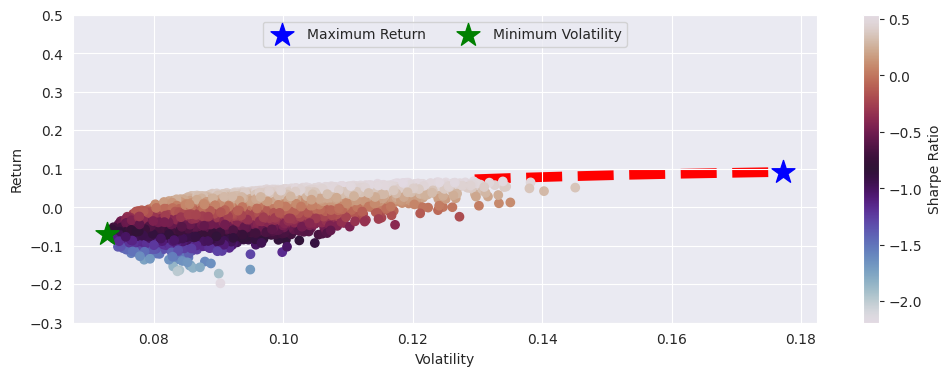

Minimum Volatility Portfolio Performance (Return, Volatility, Sharpe Ratio): (-0.06957635039933052, 0.07269994891442767, -0.957034378129016)
Maximum Return Portfolio Performance (Return, Volatility, Sharpe Ratio): (0.09155993530878279, 0.17723140306534854, 0.5166123707491213)


In [20]:
# Perform calculations
df_close, df_logret = create_dataframes(y_pred_AAPL, y_pred_SBUX, y_pred_WMT, y_pred_JPM, y_pred_PFE)
mu, Sigma = calculate_mu_sigma(df_logret)
w_1 = min_volatility_portfolio(mu, Sigma)
w_2 = max_return_portfolio(mu, Sigma)

# Note that we used predicted values for mu and sigma.
min_vol = np.sqrt(w_1.dot(Sigma).dot(w_1))
min_vol_ret = mu.dot(w_1)
max_ret = mu.dot(w_2)
max_ret_vol = np.sqrt(w_2.dot(Sigma).dot(w_2))

print(min_vol, min_vol_ret)
print(mu, Sigma)

num_simulation = 10000
num_assets = len(df_close.columns)
all_weights, ret_arr, vol_arr, sharpe_arr = monte_carlo_simulation(mu, Sigma, num_simulation, num_assets)
x_ef, y_ef = efficient_frontier(mu, Sigma, min_vol, max_ret)

# Plot the results
plot_results(vol_arr, ret_arr, sharpe_arr, x_ef, y_ef, min_vol, min_vol_ret, max_ret, max_ret_vol)


# Calculate performance metrics for the minimum volatility portfolio
min_vol_perf = portfolio_performance(w_1, mu, Sigma)
print("Minimum Volatility Portfolio Performance (Return, Volatility, Sharpe Ratio):", min_vol_perf)

# Calculate performance metrics for the maximum return portfolio
max_ret_perf = portfolio_performance(w_2, mu, Sigma)
print("Maximum Return Portfolio Performance (Return, Volatility, Sharpe Ratio):", max_ret_perf)


0.09463889664141933 -0.052075313255261796
[ 0.04049091  0.09155994  0.00340479  0.05694065 -0.246405  ] [[0.02509443 0.00847416 0.00398148 0.00388474 0.00130728]
 [0.00847416 0.03141097 0.00622721 0.00802817 0.00577593]
 [0.00398148 0.00622721 0.0082893  0.0013808  0.00303507]
 [0.00388474 0.00802817 0.0013808  0.02983684 0.00234836]
 [0.00130728 0.00577593 0.00303507 0.00234836 0.01058264]]


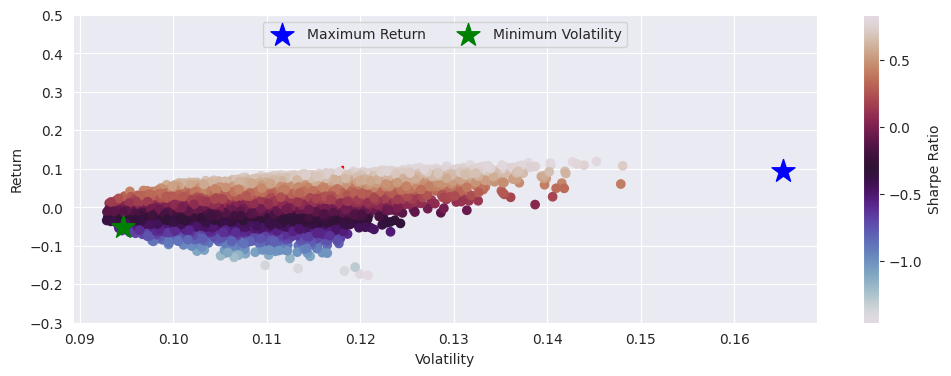

Minimum Volatility Portfolio Performance (Return, Volatility, Sharpe Ratio): (-0.052075313255261796, 0.09463889664141933, -0.5502527512822957)
Maximum Return Portfolio Performance (Return, Volatility, Sharpe Ratio): (0.09504328350450858, 0.1652172628184124, 0.5752624264751868)


In [21]:
# Perform calculations
df_close, df_logret = create_dataframes(y_pred_AAPL, y_pred_SBUX, y_pred_WMT, y_pred_JPM, y_pred_PFE)
mu, Sigma = calculate_mu_sigma(df_logret)
w_1 = min_volatility_portfolio(mu, Sigma)
w_2 = max_return_portfolio(mu, Sigma)

# Let's say we know the actual real world mu and sigma. 
df_tset_close, df_tset_logret = create_dataframes(y_test_AAPL, y_test_SBUX, y_test_WMT, y_test_JPM, y_test_PFE)
mu_pred, Sigma_pred = calculate_mu_sigma(df_tset_logret)

min_vol = np.sqrt(w_1.dot(Sigma_pred).dot(w_1))
min_vol_ret = mu_pred.dot(w_1)
max_ret = mu_pred.dot(w_2)
max_ret_vol = np.sqrt(w_2.dot(Sigma_pred).dot(w_2))

print(min_vol, min_vol_ret)
print(mu, Sigma)

num_simulation = 10000
num_assets = len(df_close.columns)
all_weights, ret_arr, vol_arr, sharpe_arr = monte_carlo_simulation(mu_pred, Sigma_pred, num_simulation, num_assets)
x_ef, y_ef = efficient_frontier(mu_pred, Sigma_pred, min_vol, max_ret)

# Plot the results
plot_results(vol_arr, ret_arr, sharpe_arr, x_ef, y_ef, min_vol, min_vol_ret, max_ret, max_ret_vol)


# Calculate performance metrics for the minimum volatility portfolio
min_vol_perf = portfolio_performance(w_1, mu_pred, Sigma_pred)
print("Minimum Volatility Portfolio Performance (Return, Volatility, Sharpe Ratio):", min_vol_perf)

# Calculate performance metrics for the maximum return portfolio
max_ret_perf = portfolio_performance(w_2, mu_pred, Sigma_pred)
print("Maximum Return Portfolio Performance (Return, Volatility, Sharpe Ratio):", max_ret_perf)


### Step 2.2. Portfolio performance (Historical 90 Days)

- By using **historical data**, you can analyze the past performance of these stocks and compare it with the results obtained using predicted prices.

In [22]:
df_close, df_logret = create_dataframes(y_val_SBUX,
                                        y_val_AAPL,
                                        y_val_WMT,
                                        y_val_JPM,
                                        y_val_PFE)

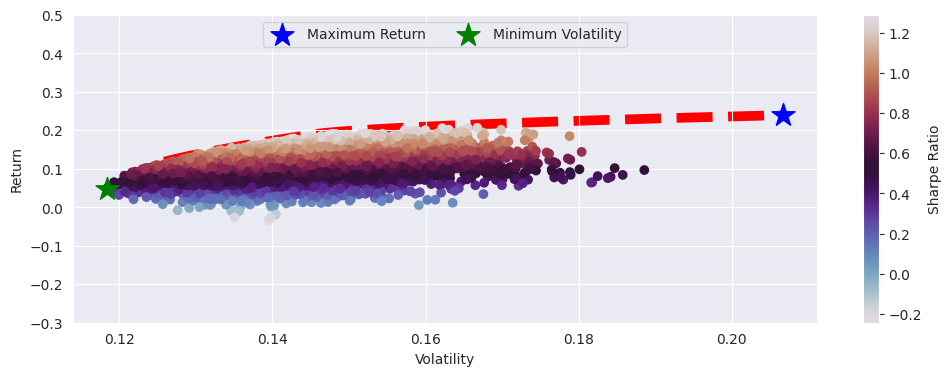

Minimum Volatility Portfolio Performance (Return, Volatility, Sharpe Ratio): (0.047099762728031035, 0.11834780254249083, 0.3979775011971231)
Maximum Return Portfolio Performance (Return, Volatility, Sharpe Ratio): (0.23921747861177184, 0.20670361356382144, 1.1572970326322403)


In [23]:
mu, Sigma = calculate_mu_sigma(df_logret)
w_1 = min_volatility_portfolio(mu, Sigma)
w_2 = max_return_portfolio(mu, Sigma)

min_vol = np.sqrt(w_1.dot(Sigma).dot(w_1))
min_vol_ret = mu.dot(w_1)
max_ret = mu.dot(w_2)
max_ret_vol = np.sqrt(w_2.dot(Sigma).dot(w_2))

num_simulation = 10000
num_assets = len(df_close.columns)
all_weights, ret_arr, vol_arr, sharpe_arr = monte_carlo_simulation(mu, Sigma, num_simulation, num_assets)
x_ef, y_ef = efficient_frontier(mu, Sigma, min_vol, max_ret)

# Plot the results
plot_results(vol_arr, ret_arr, sharpe_arr, x_ef, y_ef, min_vol, min_vol_ret, max_ret, max_ret_vol)

# Calculate performance metrics for the minimum volatility portfolio
min_vol_perf = portfolio_performance(w_1, mu, Sigma)
print("Minimum Volatility Portfolio Performance (Return, Volatility, Sharpe Ratio):", min_vol_perf)

# Calculate performance metrics for the maximum return portfolio
max_ret_perf = portfolio_performance(w_2, mu, Sigma)
print("Maximum Return Portfolio Performance (Return, Volatility, Sharpe Ratio):", max_ret_perf)


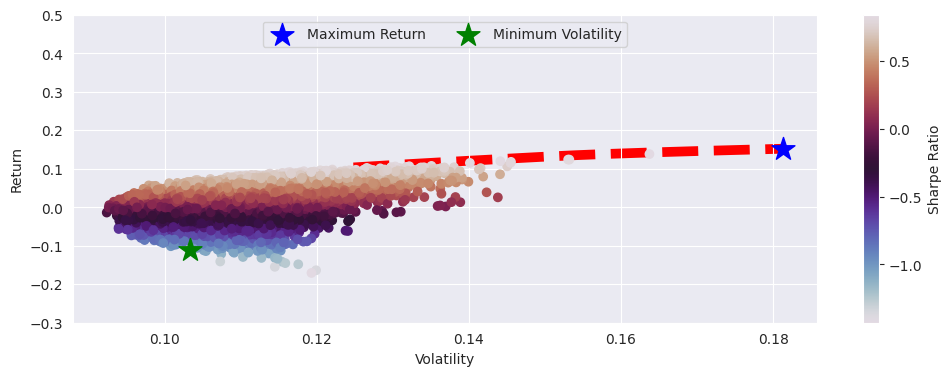

Minimum Volatility Portfolio Performance (Return, Volatility, Sharpe Ratio): (-0.11145522200143172, 0.10339669959311824, -1.0779379074963222)
Maximum Return Portfolio Performance (Return, Volatility, Sharpe Ratio): (0.1518701174275244, 0.18131053739333258, 0.8376243301185494)


In [24]:
# Perform calculations
mu, Sigma = calculate_mu_sigma(df_logret)
w_1 = min_volatility_portfolio(mu, Sigma)
w_2 = max_return_portfolio(mu, Sigma)

# Let's say we know the actual real world mu and sigma. 
df_tset_close, df_tset_logret = create_dataframes(y_test_AAPL, y_test_SBUX, y_test_WMT, y_test_JPM, y_test_PFE)
mu_pred, Sigma_pred = calculate_mu_sigma(df_tset_logret)

min_vol = np.sqrt(w_1.dot(Sigma_pred).dot(w_1))
min_vol_ret = mu_pred.dot(w_1)
max_ret = mu_pred.dot(w_2)
max_ret_vol = np.sqrt(w_2.dot(Sigma_pred).dot(w_2))

num_simulation = 10000
num_assets = len(df_close.columns)
all_weights, ret_arr, vol_arr, sharpe_arr = monte_carlo_simulation(mu_pred, Sigma_pred, num_simulation, num_assets)
x_ef, y_ef = efficient_frontier(mu_pred, Sigma_pred, min_vol, max_ret)

# Plot the results
plot_results(vol_arr, ret_arr, sharpe_arr, x_ef, y_ef, min_vol, min_vol_ret, max_ret, max_ret_vol)


# Calculate performance metrics for the minimum volatility portfolio
min_vol_perf = portfolio_performance(w_1, mu_pred, Sigma_pred)
print("Minimum Volatility Portfolio Performance (Return, Volatility, Sharpe Ratio):", min_vol_perf)

# Calculate performance metrics for the maximum return portfolio
max_ret_perf = portfolio_performance(w_2, mu_pred, Sigma_pred)
print("Maximum Return Portfolio Performance (Return, Volatility, Sharpe Ratio):", max_ret_perf)


# Step 2.3 Main problem result

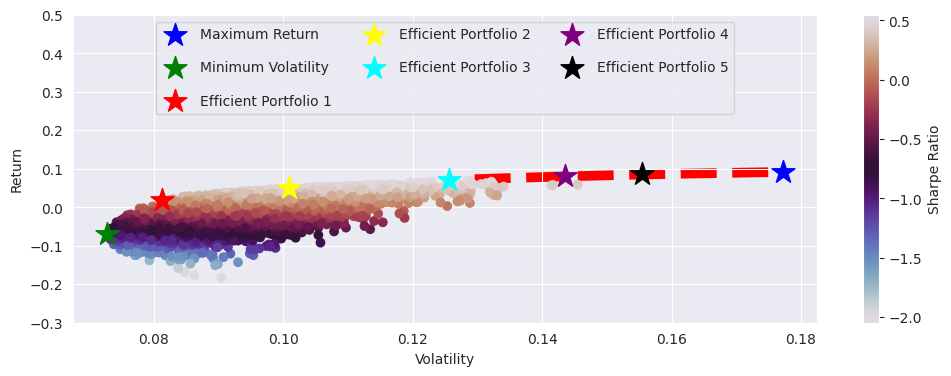

Minimum Volatility Portfolio Performance (Return, Volatility, Sharpe Ratio): (-0.06957635039933052, 0.07269994891442767, -0.957034378129016)
Maximum Return Portfolio Performance (Return, Volatility, Sharpe Ratio): (0.09155993530878279, 0.17723140306534854, 0.5166123707491213)
Efficient Portfolio 1 Performance (Return, Volatility, Sharpe Ratio): (0.020000000000000007, 0.08128151078068595, 0.24605841854938051)
Efficient Portfolio 2 Performance (Return, Volatility, Sharpe Ratio): (0.05000000000000002, 0.10089342023014237, 0.4955724554281914)
Efficient Portfolio 3 Performance (Return, Volatility, Sharpe Ratio): (0.07000000000000002, 0.12558154068006866, 0.557406762338837)
Efficient Portfolio 4 Performance (Return, Volatility, Sharpe Ratio): (0.08000000000000002, 0.14351371076289748, 0.5574380285669707)
Efficient Portfolio 5 Performance (Return, Volatility, Sharpe Ratio): (0.08500000000000003, 0.15547374371817865, 0.5467161076025564)


In [25]:
# Perform calculations
df_close, df_logret = create_dataframes(y_pred_AAPL, y_pred_SBUX, y_pred_WMT, y_pred_JPM, y_pred_PFE)
mu, Sigma = calculate_mu_sigma(df_logret)
w_1 = min_volatility_portfolio(mu, Sigma)
w_2 = max_return_portfolio(mu, Sigma)
w_list = [mean_variance_efficient_portfolio(mu, Sigma, 0.02),
          mean_variance_efficient_portfolio(mu, Sigma, 0.05),
          mean_variance_efficient_portfolio(mu, Sigma, 0.07),
          mean_variance_efficient_portfolio(mu, Sigma, 0.08),
          mean_variance_efficient_portfolio(mu, Sigma, 0.085),]

# Note that we used predicted values for mu and sigma.
min_vol = np.sqrt(w_1.dot(Sigma).dot(w_1))
min_vol_ret = mu.dot(w_1)
max_ret = mu.dot(w_2)
max_ret_vol = np.sqrt(w_2.dot(Sigma).dot(w_2))

num_simulation = 10000
num_assets = len(df_close.columns)
all_weights, ret_arr, vol_arr, sharpe_arr = monte_carlo_simulation(mu, Sigma, num_simulation, num_assets)
x_ef, y_ef = efficient_frontier(mu, Sigma, min_vol, max_ret)

# Plot the results
plot_results(vol_arr, ret_arr, sharpe_arr, x_ef, y_ef, min_vol, min_vol_ret, max_ret, max_ret_vol,
             mu, Sigma, w_list, "answer_1.png")

                                                                                                   
# Calculate performance metrics for the minimum volatility portfolio
min_vol_perf = portfolio_performance(w_1, mu, Sigma)
print("Minimum Volatility Portfolio Performance (Return, Volatility, Sharpe Ratio):", min_vol_perf)

# Calculate performance metrics for the maximum return portfolio
max_ret_perf = portfolio_performance(w_2, mu, Sigma)
print("Maximum Return Portfolio Performance (Return, Volatility, Sharpe Ratio):", max_ret_perf)

# Calculate performance metrics for the efficient portfolio
for i, efficient_portfolio in enumerate(w_list):
    perf = portfolio_performance(efficient_portfolio, mu, Sigma)
    print(f"Efficient Portfolio {i + 1} Performance (Return, Volatility, Sharpe Ratio):", perf)


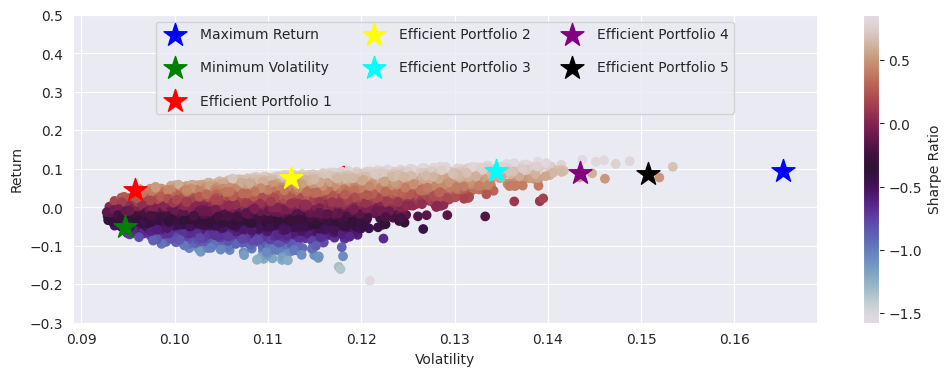

Minimum Volatility Portfolio Performance (Return, Volatility, Sharpe Ratio): (-0.052075313255261796, 0.09463889664141933, -0.5502527512822957)
Maximum Return Portfolio Performance (Return, Volatility, Sharpe Ratio): (0.09504328350450858, 0.1652172628184124, 0.5752624264751868)
Efficient Portfolio 1 Performance (Return, Volatility, Sharpe Ratio): (0.04429154064524085, 0.09572224013389995, 0.46270898574128794)
Efficient Portfolio 2 Performance (Return, Volatility, Sharpe Ratio): (0.07478306930307169, 0.11246185989623737, 0.6649638319344006)
Efficient Portfolio 3 Performance (Return, Volatility, Sharpe Ratio): (0.09508278579131116, 0.13449127432512803, 0.7069810756752278)
Efficient Portfolio 4 Performance (Return, Volatility, Sharpe Ratio): (0.08775304739466337, 0.14346256153218445, 0.6116790782031089)
Efficient Portfolio 5 Performance (Return, Volatility, Sharpe Ratio): (0.08734852158525022, 0.15070568058022019, 0.579596742796665)


In [26]:
# Perform calculations
df_close, df_logret = create_dataframes(y_pred_AAPL, y_pred_SBUX, y_pred_WMT, y_pred_JPM, y_pred_PFE)
mu, Sigma = calculate_mu_sigma(df_logret)
w_1 = min_volatility_portfolio(mu, Sigma)
w_2 = max_return_portfolio(mu, Sigma)
w_list = [mean_variance_efficient_portfolio(mu, Sigma, 0.02),
          mean_variance_efficient_portfolio(mu, Sigma, 0.05),
          mean_variance_efficient_portfolio(mu, Sigma, 0.07),
          mean_variance_efficient_portfolio(mu, Sigma, 0.08),
          mean_variance_efficient_portfolio(mu, Sigma, 0.085),]

# Let's say we know the actual real world mu and sigma. 
df_tset_close, df_tset_logret = create_dataframes(y_test_AAPL, y_test_SBUX, y_test_WMT, y_test_JPM, y_test_PFE)
mu_pred, Sigma_pred = calculate_mu_sigma(df_tset_logret)

min_vol = np.sqrt(w_1.dot(Sigma_pred).dot(w_1))
min_vol_ret = mu_pred.dot(w_1)
max_ret = mu_pred.dot(w_2)
max_ret_vol = np.sqrt(w_2.dot(Sigma_pred).dot(w_2))

num_simulation = 10000
num_assets = len(df_close.columns)
all_weights, ret_arr, vol_arr, sharpe_arr = monte_carlo_simulation(mu_pred, Sigma_pred, num_simulation, num_assets)
x_ef, y_ef = efficient_frontier(mu_pred, Sigma_pred, min_vol, max_ret)

# Plot the results
plot_results(vol_arr, ret_arr, sharpe_arr, x_ef, y_ef, min_vol, min_vol_ret, max_ret, max_ret_vol,
             mu_pred, Sigma_pred, w_list, "answer_2.png")


# Calculate performance metrics for the minimum volatility portfolio
min_vol_perf = portfolio_performance(w_1, mu_pred, Sigma_pred)
print("Minimum Volatility Portfolio Performance (Return, Volatility, Sharpe Ratio):", min_vol_perf)

# Calculate performance metrics for the maximum return portfolio
max_ret_perf = portfolio_performance(w_2, mu_pred, Sigma_pred)
print("Maximum Return Portfolio Performance (Return, Volatility, Sharpe Ratio):", max_ret_perf)

# Calculate performance metrics for the efficient portfolio
for i, efficient_portfolio in enumerate(w_list):
    perf = portfolio_performance(efficient_portfolio, mu_pred, Sigma_pred)
    print(f"Efficient Portfolio {i + 1} Performance (Return, Volatility, Sharpe Ratio):", perf)


In [27]:
df_close, df_logret = create_dataframes(y_val_SBUX,
                                        y_val_AAPL,
                                        y_val_WMT,
                                        y_val_JPM,
                                        y_val_PFE)

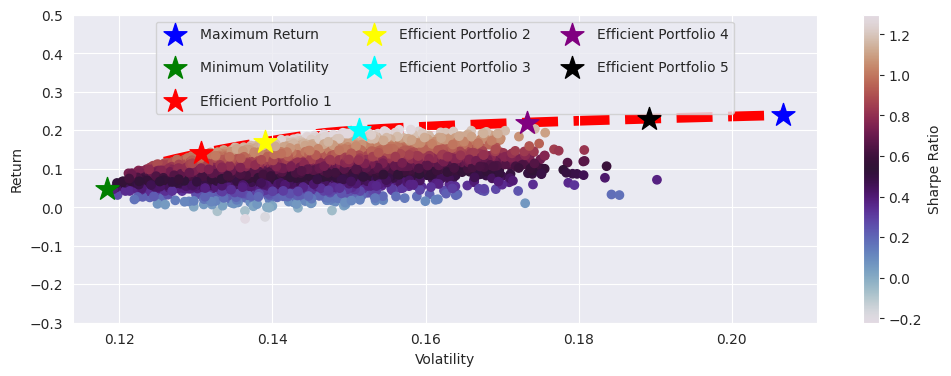

Minimum Volatility Portfolio Performance (Return, Volatility, Sharpe Ratio): (0.047099762728031035, 0.11834780254249083, 0.3979775011971231)
Maximum Return Portfolio Performance (Return, Volatility, Sharpe Ratio): (0.23921747861177184, 0.20670361356382144, 1.1572970326322403)
Efficient Portfolio 1 Performance (Return, Volatility, Sharpe Ratio): (0.14, 0.1307238621744108, 1.0709597901354313)
Efficient Portfolio 2 Performance (Return, Volatility, Sharpe Ratio): (0.17, 0.13907859481249127, 1.2223304400594328)
Efficient Portfolio 3 Performance (Return, Volatility, Sharpe Ratio): (0.19999999999999998, 0.15125040883820445, 1.322310475298906)
Efficient Portfolio 4 Performance (Return, Volatility, Sharpe Ratio): (0.22000000000000003, 0.1732314084482767, 1.269977551823043)
Efficient Portfolio 5 Performance (Return, Volatility, Sharpe Ratio): (0.22999999999999995, 0.189224410225136, 1.2154880003396489)


In [28]:
mu, Sigma = calculate_mu_sigma(df_logret)
w_1 = min_volatility_portfolio(mu, Sigma)
w_2 = max_return_portfolio(mu, Sigma)

w_list = [mean_variance_efficient_portfolio(mu, Sigma, 0.14),
          mean_variance_efficient_portfolio(mu, Sigma, 0.17),
          mean_variance_efficient_portfolio(mu, Sigma, 0.2),
          mean_variance_efficient_portfolio(mu, Sigma, 0.22),
          mean_variance_efficient_portfolio(mu, Sigma, 0.23),]

min_vol = np.sqrt(w_1.dot(Sigma).dot(w_1))
min_vol_ret = mu.dot(w_1)
max_ret = mu.dot(w_2)
max_ret_vol = np.sqrt(w_2.dot(Sigma).dot(w_2))

num_simulation = 10000
num_assets = len(df_close.columns)
all_weights, ret_arr, vol_arr, sharpe_arr = monte_carlo_simulation(mu, Sigma, num_simulation, num_assets)
x_ef, y_ef = efficient_frontier(mu, Sigma, min_vol, max_ret)

# Plot the results
plot_results(vol_arr, ret_arr, sharpe_arr, x_ef, y_ef, min_vol, min_vol_ret, max_ret, max_ret_vol,
             mu, Sigma, w_list, "answer_3.png")

# Calculate performance metrics for the minimum volatility portfolio
min_vol_perf = portfolio_performance(w_1, mu, Sigma)
print("Minimum Volatility Portfolio Performance (Return, Volatility, Sharpe Ratio):", min_vol_perf)

# Calculate performance metrics for the maximum return portfolio
max_ret_perf = portfolio_performance(w_2, mu, Sigma)
print("Maximum Return Portfolio Performance (Return, Volatility, Sharpe Ratio):", max_ret_perf)

# Calculate performance metrics for the efficient portfolio
for i, efficient_portfolio in enumerate(w_list):
    perf = portfolio_performance(efficient_portfolio, mu, Sigma)
    print(f"Efficient Portfolio {i + 1} Performance (Return, Volatility, Sharpe Ratio):", perf)


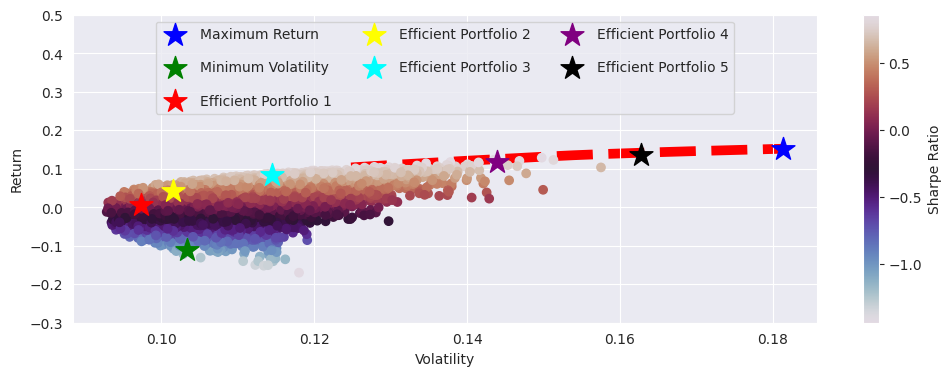

Minimum Volatility Portfolio Performance (Return, Volatility, Sharpe Ratio): (-0.11145522200143172, 0.10339669959311824, -1.0779379074963222)
Maximum Return Portfolio Performance (Return, Volatility, Sharpe Ratio): (0.1518701174275244, 0.18131053739333258, 0.8376243301185494)
Efficient Portfolio 1 Performance (Return, Volatility, Sharpe Ratio): (0.005220565925871626, 0.09739748405863499, 0.05360062404413602)
Efficient Portfolio 2 Performance (Return, Volatility, Sharpe Ratio): (0.04290354264861111, 0.10151061049272288, 0.4226508188687014)
Efficient Portfolio 3 Performance (Return, Volatility, Sharpe Ratio): (0.08435705961326674, 0.11446999166762115, 0.7369360160190165)
Efficient Portfolio 4 Performance (Return, Volatility, Sharpe Ratio): (0.11694602258245858, 0.143913425857455, 0.812613707759918)
Efficient Portfolio 5 Performance (Return, Volatility, Sharpe Ratio): (0.13511911076730435, 0.16273821052104584, 0.8302850961349996)


In [29]:
# Perform calculations
mu, Sigma = calculate_mu_sigma(df_logret)
w_1 = min_volatility_portfolio(mu, Sigma)
w_2 = max_return_portfolio(mu, Sigma)

w_list = [mean_variance_efficient_portfolio(mu, Sigma, 0.14),
          mean_variance_efficient_portfolio(mu, Sigma, 0.17),
          mean_variance_efficient_portfolio(mu, Sigma, 0.2),
          mean_variance_efficient_portfolio(mu, Sigma, 0.22),
          mean_variance_efficient_portfolio(mu, Sigma, 0.23),]


# Let's say we know the actual real world mu and sigma. 
df_tset_close, df_tset_logret = create_dataframes(y_test_AAPL, y_test_SBUX, y_test_WMT, y_test_JPM, y_test_PFE)
mu_pred, Sigma_pred = calculate_mu_sigma(df_tset_logret)

min_vol = np.sqrt(w_1.dot(Sigma_pred).dot(w_1))
min_vol_ret = mu_pred.dot(w_1)
max_ret = mu_pred.dot(w_2)
max_ret_vol = np.sqrt(w_2.dot(Sigma_pred).dot(w_2))

num_simulation = 10000
num_assets = len(df_close.columns)
all_weights, ret_arr, vol_arr, sharpe_arr = monte_carlo_simulation(mu_pred, Sigma_pred, num_simulation, num_assets)
x_ef, y_ef = efficient_frontier(mu_pred, Sigma_pred, min_vol, max_ret)


# Plot the results
plot_results(vol_arr, ret_arr, sharpe_arr, x_ef, y_ef, min_vol, min_vol_ret, max_ret, max_ret_vol,
             mu_pred, Sigma_pred, w_list, "answer_4.png")


# Calculate performance metrics for the minimum volatility portfolio
min_vol_perf = portfolio_performance(w_1, mu_pred, Sigma_pred)
print("Minimum Volatility Portfolio Performance (Return, Volatility, Sharpe Ratio):", min_vol_perf)

# Calculate performance metrics for the maximum return portfolio
max_ret_perf = portfolio_performance(w_2, mu_pred, Sigma_pred)
print("Maximum Return Portfolio Performance (Return, Volatility, Sharpe Ratio):", max_ret_perf)

# Calculate performance metrics for the efficient portfolio
for i, efficient_portfolio in enumerate(w_list):
    perf = portfolio_performance(efficient_portfolio, mu_pred, Sigma_pred)
    print(f"Efficient Portfolio {i + 1} Performance (Return, Volatility, Sharpe Ratio):", perf)




```
# 코드로 형식 지정됨
```

### Additional code (LSTM)

In [30]:


class LSTMModel(nn.Module):
    """
    Train an LSTM model for the given number of epochs.

    Args:
        model (torch.nn.Module): LSTM model to train.
        loss_fn (torch.nn.Module): Loss function to use for training.
        optimizer (torch.optim.Optimizer): Optimizer to use for training.
        num_epochs (int): Number of epochs to train the model.
        X_train (torch.FloatTensor): Training feature set.
        y_train (torch.FloatTensor): Training target set.

    Returns:
        torch.nn.Module: Trained LSTM model.
    """
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        device = x.device
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().to(device)
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :])
        return out

def train_lstm_model(model, loss_fn, optimizer, num_epochs, X_train, y_train):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    X_train = torch.FloatTensor(X_train).to(device)
    y_train = torch.FloatTensor(y_train).to(device)    
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        y_pred = model(X_train)
        loss = loss_fn(y_pred, y_train)
        loss.backward()
        optimizer.step()
        if epoch % 10 == 0:
            print(f'Epoch {epoch + 1}, Loss: {loss.item()}')
    return model


def main_LSTM(symbol):
    """
    Main function to fetch stock data, train LSTM model, and make predictions.

    Args:
        symbol (str): Stock symbol to fetch data for and train the model.

    Returns:
        tuple: Predicted stock prices, true stock prices.
    """
    args = Arguments().get_args()
    args["symbol"] = symbol

    df = fetch_stock_data(args["symbol"])
    train_df, valid_df, test_df = split_data(df, args["valid_size"], args["test_size"])

    # Prepare the data for LSTM
    scaler = MinMaxScaler(feature_range=(-1, 1))
    train_df['Close'] = scaler.fit_transform(train_df['Close'].values.reshape(-1, 1))

    seq_len = args["seq_len"]
    X_train, y_train = create_sequences(train_df['Close'], seq_len)
    X_train, y_train = torch.FloatTensor(X_train), torch.FloatTensor(y_train)

    # Create an LSTM model
    input_dim = 1
    hidden_dim = args["n_hidden"]
    num_layers = args["n_layers"]
    output_dim = 1

    lstm_model = LSTMModel(input_dim, hidden_dim, num_layers, output_dim).cuda()

    # Train the LSTM model
    loss_fn = torch.nn.MSELoss(reduction='mean')
    optimizer = torch.optim.Adam(lstm_model.parameters(), lr=0.01)
    num_epochs = 100

    lstm_model = train_lstm_model(lstm_model, loss_fn, optimizer, num_epochs, X_train, y_train)

    # Make predictions
    test_sequences = create_sequences(test_df['Close'], seq_len)
    test_inputs = torch.FloatTensor(test_sequences[0]).to("cuda:0")
    y_pred = lstm_model(test_inputs)
    y_pred = scaler.inverse_transform(y_pred.cpu().detach().numpy())

    # Evaluate the model
    y_test = test_df['Close'][seq_len:].values
    print(f'Test Mean Squared Error for {symbol}: {mean_squared_error(y_test, y_pred)}')


    return y_pred, y_test

def create_sequences(data, seq_len):
    """
    Create input-output sequences from the given time series data.

    Args:
        data (pandas.Series): Time series data.
        seq_len (int): Length of input sequences.

    Returns:
        tuple: Input and target sequences as numpy arrays.
    """
    inputs = []
    targets = []

    for i in range(len(data) - seq_len):
        inputs.append(data.iloc[i:i + seq_len].tolist())
        targets.append(data.iloc[i + seq_len])

    return np.expand_dims(np.array(inputs), 2), np.array(targets)




In [31]:
y_LSTM_pred_SBUX,y_LSTM_test_SBUX = main_LSTM("SBUX")
y_LSTM_pred_AAPL,y_LSTM_test_AAPL = main_LSTM("AAPL")
y_LSTM_pred_WMT ,y_LSTM_test_WMT = main_LSTM("WMT")
y_LSTM_pred_JPM ,y_LSTM_test_JPM = main_LSTM("JPM")
y_LSTM_pred_PFE ,y_LSTM_test_PFE = main_LSTM("PFE")

Epoch 1, Loss: 0.2581122815608978
Epoch 11, Loss: 0.25085413455963135
Epoch 21, Loss: 0.25106751918792725
Epoch 31, Loss: 0.2508692145347595
Epoch 41, Loss: 0.2508511543273926
Epoch 51, Loss: 0.2508541941642761
Epoch 61, Loss: 0.2508445382118225
Epoch 71, Loss: 0.25084564089775085
Epoch 81, Loss: 0.2508445382118225
Epoch 91, Loss: 0.25084441900253296
Test Mean Squared Error for SBUX: 516.6904180778074
Epoch 1, Loss: 0.5041302442550659
Epoch 11, Loss: 0.3687534034252167
Epoch 21, Loss: 0.3675193190574646
Epoch 31, Loss: 0.36738377809524536
Epoch 41, Loss: 0.36740514636039734
Epoch 51, Loss: 0.3673989474773407
Epoch 61, Loss: 0.36738866567611694
Epoch 71, Loss: 0.3673803508281708
Epoch 81, Loss: 0.36737748980522156
Epoch 91, Loss: 0.36737680435180664
Test Mean Squared Error for AAPL: 4895.750170985112
Epoch 1, Loss: 0.4276595413684845
Epoch 11, Loss: 0.30684414505958557
Epoch 21, Loss: 0.3054117262363434
Epoch 31, Loss: 0.305363267660141
Epoch 41, Loss: 0.30538901686668396
Epoch 51, Loss